In [1]:
import re
from pathlib import Path
from itertools import zip_longest

import numpy as np

import jax
import jax.lax
from jax.random import PRNGKey
import jax.numpy as jnp
import optax
from flax.training.train_state import TrainState
from flax import linen as nn

import matplotlib.pyplot as plt

from typing import Optional, Tuple, Dict, Any, Sequence


data_dir = "./data"
print(f"Data resides in        : {data_dir}")

Data resides in        : ./data


In [2]:
class MultiBasisDataLoader:
    def __init__(self, data_dict: dict[str, jnp.ndarray],
                 batch_size: int = 128,
                 shuffle: bool = True,
                 drop_last: bool = False,
                 seed: int = 0):
        lengths = [len(v) for v in data_dict.values()]
        if len(set(lengths)) != 1:
            raise ValueError(f"All arrays must have the same length, got: {lengths}")

        self.data = data_dict
        self.n = lengths[0]
        self.bs = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.rng = np.random.default_rng(seed)

        self.idx_slices = [
            (i, i + batch_size)
            for i in range(0, self.n, batch_size)
            if not drop_last or i + batch_size <= self.n
        ]

    def __iter__(self):
        self.order = np.arange(self.n)
        if self.shuffle:
            self.rng.shuffle(self.order)
        self.slice_idx = 0
        return self

    def __next__(self):
        if self.slice_idx >= len(self.idx_slices):
            raise StopIteration
        s, e = self.idx_slices[self.slice_idx]
        self.slice_idx += 1
        return {k: v[self.order[s:e]] for k, v in self.data.items()}


def load_measurements(folder: str, file_pattern: str = "w_*.txt") -> dict[str, jnp.ndarray]:
    out: dict[str, jnp.ndarray] = {}

    for fp in Path(folder).glob(file_pattern):
        basis = fp.stem.split("_")[2]

        bitstrings = []
        with fp.open() as f:
            for line in f:
                bitstring = np.fromiter((c.islower() for c in line.strip()), dtype=np.float32)
                bitstrings.append(bitstring)

        arr = jnp.asarray(np.stack(bitstrings))
        if basis in out:
            out[basis] = jnp.concatenate([out[basis], arr], axis=0)
        else:
            out[basis] = arr

    return out

In [3]:
data_dict = load_measurements("data/", "w_*.txt")

keys_amp = [k for k in data_dict if re.fullmatch(r"^Z+$", k)]
keys_pha = [k for k in data_dict if re.fullmatch(r"^(?!Z+$).*", k)]
dict_amp = {k: data_dict[k] for k in keys_amp}
dict_pha = {k: data_dict[k] for k in keys_pha}

loader_amp = MultiBasisDataLoader(dict_amp, batch_size=128)
loader_pha = MultiBasisDataLoader(dict_pha, batch_size=128)

In [4]:
class RBM(nn.Module):
    n_visible: int
    n_hidden: int
    k: int = 1
    n_chains: int = 1000

    @nn.compact
    def __call__(self, data_batch: jnp.ndarray, aux_vars: Optional[Dict[str, Any]] = None) -> Tuple[jnp.ndarray, Dict[str, Any]]:
        W = self.param("W", nn.initializers.normal(0.01), (self.n_visible, self.n_hidden))
        b = self.param("b", nn.initializers.zeros,        (self.n_visible,))
        c = self.param("c", nn.initializers.zeros,        (self.n_hidden,))
        key = aux_vars["key"]

        key, bern_key = jax.random.split(key, 2)
        v_chain_batch = jax.random.bernoulli(bern_key, p=0.5, shape=(self.n_chains, self.n_visible)).astype(jnp.float32)
        model_batch, key = self._gibbs_sample(W, b, c, v_chain_batch, key, k=self.k)
        model_batch = jax.lax.stop_gradient(model_batch)

        free_energy_data = self._free_energy(W, b, c, data_batch)
        free_energy_model = self._free_energy(W, b, c, model_batch)

        loss = jnp.mean(free_energy_data) - jnp.mean(free_energy_model)
        aux_vars["key"] = key

        return loss, aux_vars

    @staticmethod
    def _free_energy(W, b, c, v_batch):
        visible_term = jnp.dot(v_batch, b)
        hidden_term  = jnp.sum(jax.nn.softplus(v_batch @ W + c), axis=-1)
        free_energy = -visible_term - hidden_term
        return free_energy

    @staticmethod
    def _gibbs_step(i, state, W, b, c, T=1.0):
        v_batch, key = state
        key, h_key, v_key = jax.random.split(key, 3)

        h_logits = (v_batch @ W + c) / T
        h_probs = jax.nn.sigmoid(h_logits)
        h = jax.random.bernoulli(h_key, h_probs).astype(jnp.float32)

        v_logits = (h @ W.T + b) / T
        v_probs = jax.nn.sigmoid(v_logits)
        v = jax.random.bernoulli(v_key, v_probs).astype(jnp.float32)

        return v, key

    @staticmethod
    def _gibbs_sample(W, b, c, v_batch, rng, k=1, T=1.0):
        body_fun = lambda i, state: RBM._gibbs_step(i, state, W, b, c, T)
        v_final, key = jax.lax.fori_loop(0, k, body_fun, (v_batch, rng))
        return v_final, key

In [5]:
@jax.jit
def train_step_amp(
        state: TrainState,
        batch_dict: Dict[str, jnp.ndarray],
        aux_vars: Dict[str, Any]) -> Tuple[TrainState, jnp.ndarray, Dict[str, Any]]:

    if len(batch_dict) != 1:
        raise ValueError("Batch dictionary must contain exactly one entry.")

    (key, batch), = batch_dict.items()
    if set(key) != {'Z'}:
        raise ValueError(f"Batch key must consist only of 'Z', got: {key}")

    loss_fn = lambda params: state.apply_fn({'params': params}, batch, aux_vars)
    value_and_grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

    (loss, aux_vars), grads = value_and_grad_fn(state.params)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss, aux_vars


def train_amp_rbm(
        state: TrainState,
        loader: MultiBasisDataLoader,
        num_epochs: int,
        rng: PRNGKey) -> Tuple[TrainState, Dict[int, float], PRNGKey]:

    metrics = {}
    aux_vars = {"key": rng}

    for epoch in range(num_epochs):
        tot_loss = 0.0
        batches = 0

        for data_batch in loader:
            state, loss, aux_vars = train_step_amp(state, data_batch, aux_vars)
            tot_loss += loss
            batches += 1

        metrics[epoch] = {"loss_amp": float(tot_loss / batches)}
        print(f"Epoch {epoch+1}/{num_epochs} │ Loss: {metrics[epoch]['loss_amp']:.4f}")

    return state, metrics, aux_vars["key"]

In [6]:
# ---- hyperparameters ----
batch_size    = 6400
visible_units = 10
hidden_units  = 10
k_steps       = 2
lr            = 1e-2
num_epochs    = 100
chains        = 1000

random_seed = PRNGKey(42)
rng, init_key = jax.random.split(random_seed)

# model initialization
model_amp = RBM(n_visible=visible_units, n_hidden=hidden_units, k=k_steps, n_chains=chains)
dummy_batch = jnp.zeros((batch_size, visible_units), dtype=jnp.float32)
variables_amp = model_amp.init(init_key, dummy_batch, {"key": rng})

optimizer_amp = optax.adam(learning_rate=lr)
state_amp = TrainState.create(apply_fn=model_amp.apply, params=variables_amp["params"], tx=optimizer_amp)

In [7]:
state_amp, metrics, rng = train_amp_rbm(
    state_amp,
    loader_amp,
    num_epochs,
    rng
)

Epoch 1/100 │ Loss: -1.3918
Epoch 2/100 │ Loss: -0.3476
Epoch 3/100 │ Loss: -0.0493
Epoch 4/100 │ Loss: -0.0952
Epoch 5/100 │ Loss: -0.0903
Epoch 6/100 │ Loss: -0.0890
Epoch 7/100 │ Loss: -0.0777
Epoch 8/100 │ Loss: -0.0559
Epoch 9/100 │ Loss: -0.0526
Epoch 10/100 │ Loss: -0.0552
Epoch 11/100 │ Loss: -0.0441
Epoch 12/100 │ Loss: -0.0470
Epoch 13/100 │ Loss: -0.0270
Epoch 14/100 │ Loss: -0.0265
Epoch 15/100 │ Loss: -0.0299
Epoch 16/100 │ Loss: -0.0300
Epoch 17/100 │ Loss: -0.0183
Epoch 18/100 │ Loss: -0.0250
Epoch 19/100 │ Loss: -0.0157
Epoch 20/100 │ Loss: -0.0219
Epoch 21/100 │ Loss: -0.0223
Epoch 22/100 │ Loss: -0.0088
Epoch 23/100 │ Loss: -0.0067
Epoch 24/100 │ Loss: -0.0129
Epoch 25/100 │ Loss: -0.0175
Epoch 26/100 │ Loss: -0.0081
Epoch 27/100 │ Loss: -0.0106
Epoch 28/100 │ Loss: -0.0023
Epoch 29/100 │ Loss: -0.0108
Epoch 30/100 │ Loss: 0.0043
Epoch 31/100 │ Loss: -0.0133
Epoch 32/100 │ Loss: -0.0013
Epoch 33/100 │ Loss: 0.0050
Epoch 34/100 │ Loss: -0.0127
Epoch 35/100 │ Loss: -0.0

Text(0, 0.5, 'Free Energy Loss')

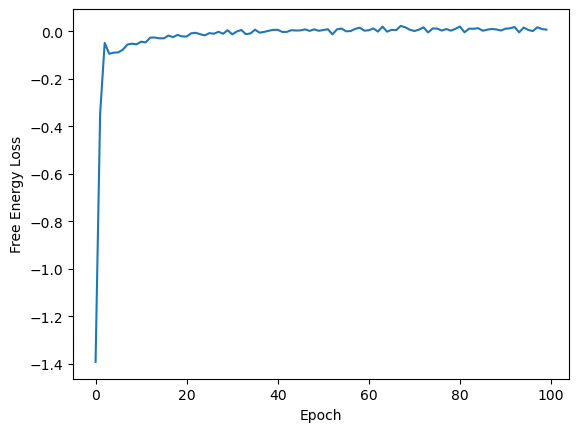

In [8]:
plt.plot([metrics[epoch]['loss_amp'] for epoch in metrics])
plt.xlabel("Epoch")
plt.ylabel("Free Energy Loss")

In [22]:
class PairPhaseRBM(nn.Module):
    n_visible: int
    n_hidden: int

    def setup(self):
        # We’ll copy the learned amp weights in later, so a dummy zero init is fine.
        zeros = lambda shape: jnp.zeros(shape, dtype=jnp.float32)

        # ---  amplitude state (mutable, not trained here) ---
        self.W_amp = self.variable('amp_state', 'W_amp', zeros, (self.n_visible, self.n_hidden)        )
        self.b_amp = self.variable('amp_state', 'b_amp', zeros, (self.n_visible,))
        self.c_amp = self.variable('amp_state', 'c_amp', zeros, (self.n_hidden,))

        # ---  phase-RBM trainable parameters  ---
        initW = nn.initializers.normal(0.01)
        init0 = nn.initializers.zeros
        self.W_pha = self.param('W_pha', initW, (self.n_visible, self.n_hidden))
        self.b_pha = self.param('b_pha', init0, (self.n_visible,))
        self.c_pha = self.param('c_pha', init0, (self.n_hidden,))

        # ---  single-qubit rotators  ---
        sqrt2 = jnp.sqrt(2.0)
        self.rotators = {
            'X': jnp.array([[1, 1], [1, -1]], dtype=jnp.complex64) / sqrt2,
            'Y': jnp.array([[1, -1j], [1, 1j]], dtype=jnp.complex64) / sqrt2
        }

    def __call__(self, data_batch_dict: Dict[str, jnp.ndarray]) -> jnp.ndarray:
        # Retrieve amp state and phase params
        W_amp = self.W_amp.value
        b_amp = self.b_amp.value
        c_amp = self.c_amp.value
        W_pha = self.W_pha
        b_pha = self.b_pha
        c_pha = self.c_pha

        losses = []
        for basis, batch in data_batch_dict.items():
            logp = self.get_rotated_log_prob(
                sigma_b=batch,
                basis=basis,
                W_amp=W_amp, b_amp=b_amp, c_amp=c_amp,
                W_pha=W_pha, b_pha=b_pha, c_pha=c_pha
            )
            losses.append(-jnp.mean(logp))
        return jnp.sum(jnp.stack(losses))

    @staticmethod
    def _free_energy(W: jnp.ndarray, b: jnp.ndarray, c: jnp.ndarray, v: jnp.ndarray) -> jnp.ndarray:
        visible = jnp.dot(v, b)
        hidden  = jnp.sum(jax.nn.softplus(v @ W + c), axis=-1)
        return -visible - hidden

    def get_rotated_log_prob(
            self,
            sigma_b: jnp.ndarray,
            basis: Sequence[str],
            W_amp: jnp.ndarray, b_amp: jnp.ndarray, c_amp: jnp.ndarray,
            W_pha: jnp.ndarray, b_pha: jnp.ndarray, c_pha: jnp.ndarray,
            eps: float = 1e-12
    ) -> jnp.ndarray:
        B, n = sigma_b.shape
        # Identify two non-Z qubits
        non_z = [i for i, p in enumerate(basis) if p != 'Z']
        if len(non_z) != 2:
            raise ValueError('Requires two non-Z qubits.')
        j, k = non_z

        # Build 2-qubit rotation U
        Rj = self.rotators[basis[j]]
        Rk = self.rotators[basis[k]]
        U  = jnp.kron(Rj, Rk)  # shape (4,4)

        # Enumerate local bit configurations
        combos = jnp.array([[0.,0.],[0.,1.],[1.,0.],[1.,1.]], dtype=sigma_b.dtype)
        tiled  = jnp.tile(sigma_b[:, None, :], (1,4,1))
        modified = tiled.at[:, :, [j, k]].set(combos[None, :, :])
        flat   = modified.reshape(B*4, n)

        # Compute free energies
        F_amp = self._free_energy(W_amp, b_amp, c_amp, flat)
        F_pha = self._free_energy(W_pha, b_pha, c_pha, flat)

        # Magnitudes & phases
        log_mag = (-0.5 * F_amp).reshape(B,4)
        angle   = (-0.5 * F_pha).reshape(B,4)
        M       = jnp.max(log_mag, axis=1, keepdims=True)
        scaled  = jnp.exp(log_mag - M + 1j * angle)

        # Select U columns and accumulate
        idx   = (sigma_b[:, j].astype(int) << 1) | sigma_b[:, k].astype(int)
        Uc    = U[:, idx].T
        S     = jnp.sum(Uc * scaled, axis=1)
        return 2.0 * (M.squeeze() + jnp.log(jnp.abs(S) + eps))

In [23]:
@jax.jit
def train_step_pha(
        state: TrainState,
        amp_vars: Dict[str, jnp.ndarray],
        batch_dict: Dict[str, jnp.ndarray]) -> Tuple[TrainState, jnp.ndarray]:

    model_var_dict = { 'params': state.params, 'amp_state': amp_vars }
    loss_fn = lambda params: state.apply_fn(model_var_dict, batch_dict)
    value_and_grad_fn = jax.value_and_grad(loss_fn)

    loss, grad = value_and_grad_fn(state.params)
    new_state = state.apply_gradients(grads=grad)
    return new_state, loss


def train_phase_rbm(
        state_pha: TrainState,
        amp_vars: Dict[str, jnp.ndarray],
        loader: MultiBasisDataLoader,
        num_epochs: int) -> Tuple[TrainState, Dict[int, float]]:

    metrics = {}

    for epoch in range(num_epochs):
        tot_loss = 0.0
        batches = 0

        for batch_dict in loader:
            state_pha, loss = train_step_pha(state_pha, amp_vars, batch_dict)
            tot_loss += loss
            batches += 1

        metrics[epoch] = {"loss_pha": float(tot_loss / batches)}
        print(f"Epoch {epoch+1}/{num_epochs} │ Loss: {metrics[epoch]['loss_pha']:.4f}")

    return state_pha, metrics

In [ ]:
batch_size    = 6400
lr            = 1e-2
num_epochs    = 10


model_pha = PairPhaseRBM(n_visible=visible_units, n_hidden=hidden_units)
dummy_dict = next(iter(loader_pha))
variables_pha  = model_pha.init(rng, dummy_dict)

optimizer_pha = optax.adam(learning_rate=lr)
state_pha = TrainState.create(apply_fn=model_pha.apply, params=variables_pha['params'], tx=optimizer_pha)

amp_vars = {
    'W_amp': state_amp.params['W'],
    'b_amp': state_amp.params['b'],
    'c_amp': state_amp.params['c'],
}

In [26]:
state_pha, metrics_pha = train_phase_rbm(
    state_pha=state_pha,
    amp_vars=amp_vars,
    loader=loader_pha,
    num_epochs=num_epochs
)

Epoch 1/20 │ Loss: -487.6917
Epoch 2/20 │ Loss: -487.6918
Epoch 3/20 │ Loss: -487.6917
Epoch 4/20 │ Loss: -487.6917
Epoch 5/20 │ Loss: -487.6917
Epoch 6/20 │ Loss: -487.6917
Epoch 7/20 │ Loss: -487.6917
Epoch 8/20 │ Loss: -487.6917
Epoch 9/20 │ Loss: -487.6918
Epoch 10/20 │ Loss: -487.6917
Epoch 11/20 │ Loss: -487.6917
Epoch 12/20 │ Loss: -487.6917
Epoch 13/20 │ Loss: -487.6917
Epoch 14/20 │ Loss: -487.6917
Epoch 15/20 │ Loss: -487.6918
Epoch 16/20 │ Loss: -487.6917
Epoch 17/20 │ Loss: -487.6918
Epoch 18/20 │ Loss: -487.6917
Epoch 19/20 │ Loss: -487.6917
Epoch 20/20 │ Loss: -487.6917


Text(0, 0.5, 'Phase Loss')

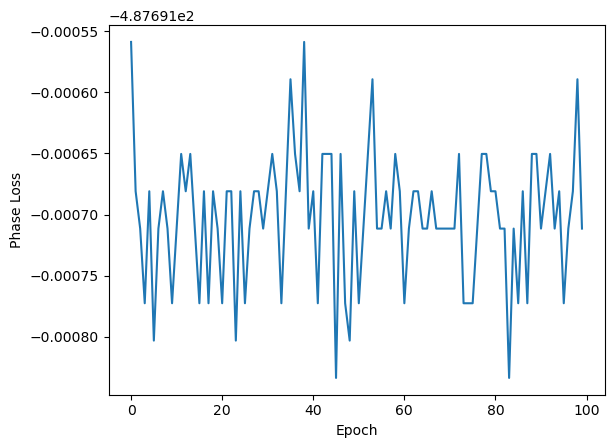

In [27]:
plt.plot([pha_metrics[e]['loss_pha'] for e in pha_metrics])
plt.xlabel("Epoch")
plt.ylabel("Phase Loss")